In [41]:
import numpy as np
from scipy import io
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [6]:
data = []
labels = []
path = "./Raw_data/"
for label in range(5):
    print(label)
    f_path = os.path.join(os.path.join(path, str(label)), "fft_data_final.mat")
    data.append(io.loadmat(f_path)["fft_data_final"])
    labels.extend([label]*data[-1].shape[2])

data = np.concatenate(data, axis=2)
labels = np.array(labels)

0
1
2
3
4


In [7]:
data.shape

(866, 256, 5000)

In [8]:
labels.shape

(5000,)

In [9]:
temp = np.where(data[0, 0, :] != 0)
train_test_data = data[:, :, temp[0]]
train_test_labels = labels[temp[0]]


In [10]:
import matplotlib.pyplot as plt

In [11]:
background_img = np.mean(train_test_data[:, :, 0:200], axis=2)

In [12]:
train_test_labels[450]

2

In [13]:
max_inds = np.unravel_index(np.argsort(train_test_data[:, :, 500] - background_img, axis=None), background_img.shape)

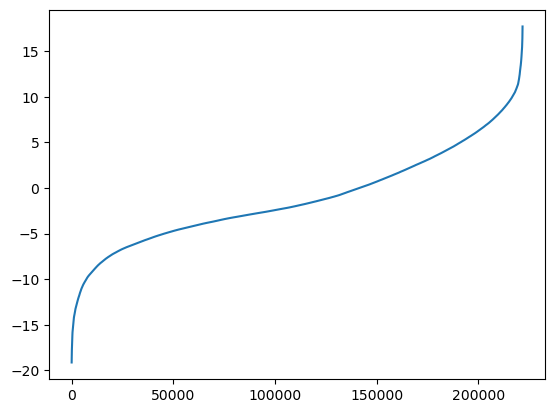

In [14]:
plt.plot(range(866*256), (train_test_data[:, :, 500] - background_img)[max_inds[0], max_inds[1]])

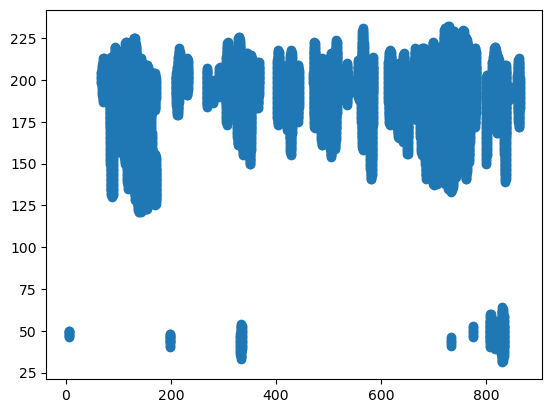

In [15]:
plt.scatter(max_inds[0][-22000:], max_inds[1][-22000:])

In [16]:
train_test_data = train_test_data - background_img[:, :, np.newaxis]

In [17]:
import torch
from sklearn.model_selection import train_test_split


train_data, test_data, train_labels, test_labels = train_test_split(np.transpose(train_test_data[:, :, :, np.newaxis], (2, 3, 0, 1)), train_test_labels.astype(int), test_size=0.2)

# Convert the training and testing data and targets to PyTorch tensors
train_data = torch.from_numpy(train_data).float()
test_data = torch.from_numpy(test_data).float()
train_labels = torch.from_numpy(train_labels).float()
test_labels = torch.from_numpy(test_labels).float()

# Define a PyTorch dataset and dataloader for the training data
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)



In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, (5, 5), padding="same")
        self.pool1 = nn.MaxPool2d(5, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, (5, 5), padding="same")
        self.pool2 = nn.MaxPool2d(5, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 16, (5, 5), padding="same")
        self.pool3 = nn.MaxPool2d(5, 5)
        self.bn3 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16*6*2, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = self.bn1(self.pool1(torch.relu(self.conv1(x))))
        x = self.bn2(self.pool2(torch.relu(self.conv2(x))))
        x = self.bn3(self.pool3(torch.relu(self.conv3(x))))
        x = x.view(-1, 16*6*2)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = Net()

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        print(loss)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    with torch.no_grad():
        out = model(test_data)
        print("test loss - {}".format(torch.nn.functional.mse_loss(out, test_labels)))

    # Print statistics
    print('[Epoch %d] loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

print('Finished Training')


tensor(6.2762, grad_fn=<MseLossBackward0>)
tensor(6.6344, grad_fn=<MseLossBackward0>)
tensor(5.0859, grad_fn=<MseLossBackward0>)
tensor(4.5463, grad_fn=<MseLossBackward0>)
tensor(4.4945, grad_fn=<MseLossBackward0>)
tensor(5.4414, grad_fn=<MseLossBackward0>)
tensor(3.3610, grad_fn=<MseLossBackward0>)
tensor(3.1061, grad_fn=<MseLossBackward0>)
tensor(2.4074, grad_fn=<MseLossBackward0>)
tensor(2.4076, grad_fn=<MseLossBackward0>)
tensor(2.2553, grad_fn=<MseLossBackward0>)
tensor(1.4933, grad_fn=<MseLossBackward0>)
tensor(2.2662, grad_fn=<MseLossBackward0>)
tensor(1.9430, grad_fn=<MseLossBackward0>)
tensor(2.3461, grad_fn=<MseLossBackward0>)
tensor(2.0602, grad_fn=<MseLossBackward0>)
tensor(2.1530, grad_fn=<MseLossBackward0>)
tensor(2.1052, grad_fn=<MseLossBackward0>)
tensor(2.2127, grad_fn=<MseLossBackward0>)
tensor(2.2671, grad_fn=<MseLossBackward0>)
tensor(2.7502, grad_fn=<MseLossBackward0>)
tensor(2.1724, grad_fn=<MseLossBackward0>)
tensor(2.4473, grad_fn=<MseLossBackward0>)
tensor(2.23

/var/folders/nv/vcg57cz17bdd5g0wq6rqp36h0000gn/T/ipykernel_37133/1088740793.py:56: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print("test loss - {}".format(torch.nn.functional.mse_loss(out, test_labels)))


test loss - 2.2409608364105225
[Epoch 1] loss: 3.034
tensor(1.8088, grad_fn=<MseLossBackward0>)
tensor(2.1162, grad_fn=<MseLossBackward0>)
tensor(1.4180, grad_fn=<MseLossBackward0>)
tensor(1.5876, grad_fn=<MseLossBackward0>)
tensor(1.8655, grad_fn=<MseLossBackward0>)
tensor(1.9835, grad_fn=<MseLossBackward0>)
tensor(2.2792, grad_fn=<MseLossBackward0>)
tensor(2.1661, grad_fn=<MseLossBackward0>)
tensor(2.8148, grad_fn=<MseLossBackward0>)
tensor(2.1248, grad_fn=<MseLossBackward0>)
tensor(2.0800, grad_fn=<MseLossBackward0>)
tensor(2.4885, grad_fn=<MseLossBackward0>)
tensor(1.6956, grad_fn=<MseLossBackward0>)
tensor(1.7421, grad_fn=<MseLossBackward0>)
tensor(1.7401, grad_fn=<MseLossBackward0>)
tensor(2.3119, grad_fn=<MseLossBackward0>)
tensor(2.0502, grad_fn=<MseLossBackward0>)
tensor(2.1986, grad_fn=<MseLossBackward0>)
tensor(1.9161, grad_fn=<MseLossBackward0>)
tensor(2.0132, grad_fn=<MseLossBackward0>)
tensor(1.9665, grad_fn=<MseLossBackward0>)
tensor(2.2633, grad_fn=<MseLossBackward0>)
t

tensor(2.1937, grad_fn=<MseLossBackward0>)
tensor(1.7084, grad_fn=<MseLossBackward0>)
tensor(2.2091, grad_fn=<MseLossBackward0>)
tensor(2.0838, grad_fn=<MseLossBackward0>)
tensor(2.1737, grad_fn=<MseLossBackward0>)
tensor(1.9094, grad_fn=<MseLossBackward0>)
tensor(1.9847, grad_fn=<MseLossBackward0>)
tensor(1.7302, grad_fn=<MseLossBackward0>)
tensor(2.0624, grad_fn=<MseLossBackward0>)
tensor(1.3763, grad_fn=<MseLossBackward0>)
tensor(1.7355, grad_fn=<MseLossBackward0>)
tensor(2.0451, grad_fn=<MseLossBackward0>)
tensor(2.1383, grad_fn=<MseLossBackward0>)
tensor(1.4876, grad_fn=<MseLossBackward0>)
tensor(2.2829, grad_fn=<MseLossBackward0>)
tensor(2.1236, grad_fn=<MseLossBackward0>)
tensor(1.6019, grad_fn=<MseLossBackward0>)
tensor(1.8569, grad_fn=<MseLossBackward0>)
tensor(2.0240, grad_fn=<MseLossBackward0>)
test loss - 2.1576504707336426
[Epoch 9] loss: 1.975
tensor(1.8735, grad_fn=<MseLossBackward0>)
tensor(1.9455, grad_fn=<MseLossBackward0>)
tensor(2.4244, grad_fn=<MseLossBackward0>)
t

In [22]:
pred_labels = model(test_data[:, :, :, :])
for i in range(len(pred_labels)): 
    pred_labels[i] = round(pred_labels[i])
actual_labels = torch.argmax(test_labels, axis=1)

TypeError: type Tensor doesn't define __round__ method

In [ ]:
pred_labels

tensor([[1.9946],
        [1.9381],
        [2.0490],
        [2.0132],
        [2.0731],
        [1.9747],
        [2.3455],
        [1.5832],
        [1.5746],
        [1.9924],
        [1.7009],
        [2.1263],
        [2.0902],
        [1.9398],
        [1.8373],
        [2.0735],
        [1.8612],
        [2.2959],
        [1.7469],
        [2.0629],
        [2.2381],
        [2.1998],
        [1.9930],
        [2.0810],
        [2.0651],
        [2.1310],
        [2.1946],
        [1.9836],
        [1.9977],
        [1.8988],
        [1.7934],
        [2.1572],
        [1.9222],
        [1.8637],
        [2.1985],
        [1.8209],
        [1.8770],
        [2.1140],
        [2.2560],
        [1.7865],
        [1.8558],
        [1.9489],
        [1.7367],
        [1.9735],
        [2.0173],
        [1.8706],
        [1.9721],
        [1.8558],
        [2.2498],
        [1.7460],
        [1.9711],
        [2.3474],
        [1.7311],
        [2.0285],
        [1.7981],
        [2

In [24]:
# use cross entropy loss

from sklearn.model_selection import train_test_split
import torch.nn.functional as F

train_data, test_data, train_labels, test_labels = train_test_split(np.transpose(train_test_data[:, :, :, np.newaxis], (2, 3, 0, 1)), train_test_labels.astype(int), test_size=0.2)

# Convert the training and testing data and targets to PyTorch tensors
train_data = torch.from_numpy(train_data).float()
test_data = torch.from_numpy(test_data).float()
train_labels = torch.from_numpy(train_labels).to(torch.int64)
test_labels = torch.from_numpy(test_labels).to(torch.int64)

train_labels = F.one_hot(train_labels, 5)
test_labels = F.one_hot(test_labels, 5)

# Define a PyTorch dataset and dataloader for the training data
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)



In [60]:
# Run this code for different model types 
import torch
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, (5, 5), padding="same")
        self.pool1 = nn.MaxPool2d(5, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, (5, 5), padding="same")
        self.pool2 = nn.MaxPool2d(5, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, (5, 5), padding="same")
        self.pool3 = nn.MaxPool2d(5, 5)
        self.bn3 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32*6*2, 16)
        self.fc2 = nn.Linear(16, 5)
        self.sm = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.bn1(self.pool1(torch.relu(self.conv1(x))))
        x = self.bn2(self.pool2(torch.relu(self.conv2(x))))
        x = self.bn3(self.pool3(torch.relu(self.conv3(x))))
        x = x.view(-1, 32*6*2)
        x = torch.relu(self.fc1(x))
        x = self.sm(self.fc2(x))
        return x

# Instantiate the model
model = Net()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_loss_data = []
test_loss_data = [] 
temp_out = 10000 
num_epochs = 100
# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        print(loss)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    with torch.no_grad():
        out = model(test_data)
        test_loss = criterion(out, test_labels.float())
        print("test loss - {}".format(criterion(out, test_labels.float())))


    train_loss = running_loss / len(train_loader) 
    if (train_loss > temp_out):
        break
    temp_out = train_loss 
    
    # Print statistics
    train_loss_data.append(temp_out)
    test_loss_data.append(test_loss)
    print('[Epoch %d] loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))
    
print('Finished Training')


tensor(1.6104, grad_fn=<DivBackward1>)
tensor(1.6092, grad_fn=<DivBackward1>)
tensor(1.5965, grad_fn=<DivBackward1>)
tensor(1.6075, grad_fn=<DivBackward1>)
tensor(1.5581, grad_fn=<DivBackward1>)
tensor(1.5603, grad_fn=<DivBackward1>)
tensor(1.5029, grad_fn=<DivBackward1>)
tensor(1.5373, grad_fn=<DivBackward1>)


KeyboardInterrupt: 

In [34]:
out = model(test_data)

In [35]:
pred_labels = torch.argmax(out, axis=1)

In [36]:
actual_labels = torch.argmax(test_labels, axis=1)

34
24
21
36
38
200


4.78

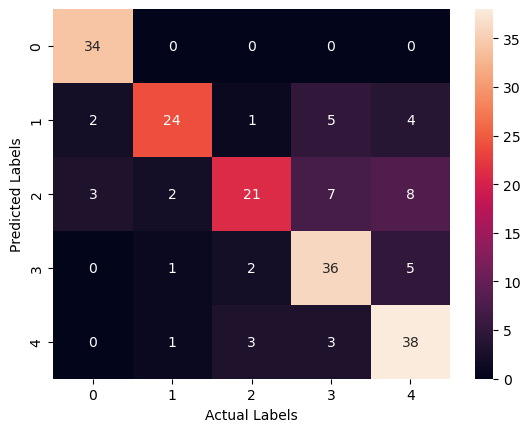

In [58]:
import seaborn as sns
cf_matrix = confusion_matrix(actual_labels, pred_labels)

s = sns.heatmap(cf_matrix, annot=True)
s.set_xlabel('Actual Labels', fontsize=10)
s.set_ylabel('Predicted Labels', fontsize=10)
for i in range(5):
    print(cf_matrix[i][i])
    true_reps += cf_matrix[i][i]
total = sum(sum(cf_matrix))
print(total)
accuracy = (true_reps/total)
accuracy


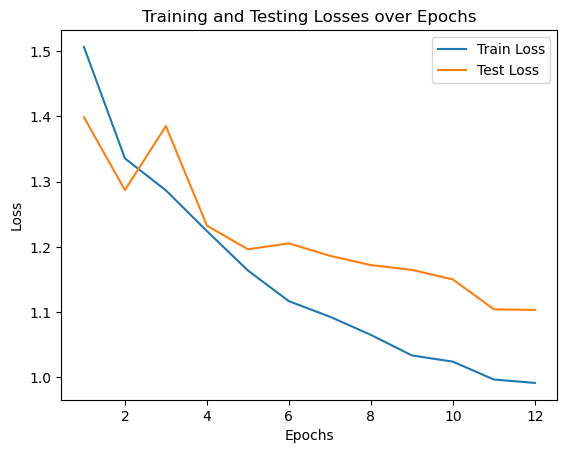

In [59]:

plt.plot(range(1, len(train_loss_data) + 1), train_loss_data, label='Train Loss')
plt.plot(range(1, len(test_loss_data) + 1), test_loss_data, label='Test Loss')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses over Epochs')
plt.legend()

# Displaying the plot
plt.show()

In [64]:
# Run this code for different model types : Model 2 
import torch
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, (5, 5), padding="same")
        self.pool1 = nn.MaxPool2d(5, 5)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, (5, 5), padding="same")
        self.pool2 = nn.MaxPool2d(5, 5)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32*6*2, 16)
        self.fc2 = nn.Linear(16, 5)
        self.sm = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.bn1(self.pool1(torch.relu(self.conv1(x))))
        x = self.bn2(self.pool2(torch.relu(self.conv2(x))))
        x = x.view(-1, 32*6*2)
        x = torch.relu(self.fc1(x))
        x = self.sm(self.fc2(x))
        return x

# Instantiate the model
model = Net()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_loss_data = []
test_loss_data = [] 
temp_out = 10000 
num_epochs = 100
# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        print(loss)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    with torch.no_grad():
        out = model(test_data)
        test_loss = criterion(out, test_labels.float())
        print("test loss - {}".format(criterion(out, test_labels.float())))


    train_loss = running_loss / len(train_loader) 
    if (train_loss > temp_out):
        break
    temp_out = train_loss 
    
    # Print statistics
    train_loss_data.append(temp_out)
    test_loss_data.append(test_loss)
    print('[Epoch %d] loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))
    
print('Finished Training')


RuntimeError: shape '[-1, 384]' is invalid for input of size 348160

In [ ]:
test_labels.shape

torch.Size([200, 5])

In [ ]:
# see data

In [13]:
img = None
for i in range(1000):
    fig = plt.figure()
    plt.imshow(train_test_data[:, :, i])
    fig.savefig("./fft_images/{}.png".format(i))
    #plt.draw()

NameError: ignored

In [ ]:
# people detection (binary)

In [ ]:
from sklearn.model_selection import train_test_split

train_test_labels = train_test_labels.astype(int)
train_test_labels[train_test_labels > 0] = 1
train_data, test_data, train_labels, test_labels = train_test_split(np.transpose(train_test_data[:, :, :, np.newaxis], (2, 3, 0, 1)), train_test_labels.astype(int), test_size=0.2)

# Convert the training and testing data and targets to PyTorch tensors
train_data = torch.from_numpy(train_data).float()
test_data = torch.from_numpy(test_data).float()
train_labels = torch.from_numpy(train_labels).float()
test_labels = torch.from_numpy(test_labels).float()

# Define a PyTorch dataset and dataloader for the training data
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)



In [5]:
# people detection 
import torch
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, (5, 5), padding="same")
        self.pool1 = nn.MaxPool2d(5, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, (5, 5), padding="same")
        self.pool2 = nn.MaxPool2d(5, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 16, (5, 5), padding="same")
        self.pool3 = nn.MaxPool2d(5, 5)
        self.bn3 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16*6*2, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = self.bn1(self.pool1(torch.relu(self.conv1(x))))
        x = self.bn2(self.pool2(torch.relu(self.conv2(x))))
        x = self.bn3(self.pool3(torch.relu(self.conv3(x))))
        x = x.view(-1, 16*6*2)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = x.flatten()
        return x

# Instantiate the model
model = Net()
print(model)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 5
# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Define the loss function
        inputs, labels = data
        class_weights = torch.tensor([0.2]*32).to("cpu")
        class_weights[labels == 0] = 0.8
        criterion = nn.BCELoss(weight=class_weights)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        print(loss)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    with torch.no_grad():
        out = model(test_data)
        print("test loss - {}".format(torch.nn.functional.mse_loss(out, test_labels)))

    # Print statistics
    print('[Epoch %d] loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

print('Finished Training')


Net(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=192, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


NameError: ignored

In [ ]:
out = model(test_data)


In [3]:
from torchvision.utils import save_image
save_image(model, "model.png")

NameError: ignored

In [ ]:
out[out > 0.5] = 1
out[out < 0.5] = 0

In [ ]:
out

tensor([1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
        1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
        0., 1.], grad_fn=<AsStridedBackward0>)

In [ ]:
test_labels

tensor([1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
        1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
        1., 1.])

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_labels.detach().numpy(), out.detach().numpy())

array([[ 42,   1],
       [  3, 154]])

<Axes: >

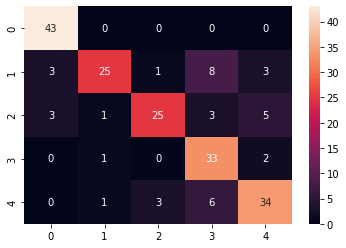

In [12]:
import seaborn as sns
hehe1 = np.array([[ 42,   1],
       [  3, 154]])

hehe2 = np.array([[43,  0,  0,  0,  0],
       [ 3, 25,  1,  8,  3],
       [ 3,  1, 25,  3,  5],
       [ 0,  1,  0, 33,  2],
       [ 0,  1,  3,  6, 34]])
#sns.heatmap(hehe1, annot=True)
sns.heatmap(hehe2, annot=True)